In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy import stats
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [2]:
pubchem_data = pd.read_csv("./Pubchem_92_assays_binary.csv") 
pubchem_data

,StdInChI,588458,588334,2642,2156,2330,2216,743015,504444,894,...,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,smiles_r
0,InChI=1S/C11H14ClN3O4S3/c1-2-3-20-6-11-14-8-4-...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,...,-0.064442,-0.083984,-0.085743,-0.049853,-0.049552,-0.053859,-0.037229,-0.036164,-0.052429,C=CCSCC1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1
1,InChI=1S/C25H27ClN2O/c26-22-12-7-13-23(18-22)2...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,-0.029972,-0.059979,-0.052889,0.017667,-0.004665,0.006729,0.070510,0.021314,0.030253,OC(CN1CCN(c2cccc(Cl)c2)CC1)C(c1ccccc1)c1ccccc1
2,InChI=1S/C18H20O2/c1-18-9-8-14-13-5-3-12(19)10...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,...,0.020276,0.022685,0.032980,-0.050662,-0.021212,-0.020383,-0.056293,-0.040187,-0.037869,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O
3,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,-0.108891,-0.148361,-0.149801,-0.022526,-0.021288,-0.024947,-0.030227,-0.081710,-0.068887,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21
4,InChI=1S/C10H14ClN3/c11-9-2-1-3-10(13-9)14-6-4...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,...,0.013632,-0.001829,0.022562,-0.157595,-0.117522,-0.119432,0.010668,-0.011003,-0.002506,NC1CCN(c2cccc(Cl)n2)CC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10397,"InChI=1S/C34H41N5O3S/c1-34(2,3)43(42)39-23-28-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.077785,0.053886,0.053411,-0.046787,-0.101272,-0.089872,-0.064416,-0.052383,-0.032502,CC(C)(C)[S@@+]([O-])N1Cc2cc(C(=O)NCCN3CCCCC3)n...
10398,"InChI=1S/C34H36N4O3S/c1-34(2,3)42(41)38-22-28-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.040793,-0.023397,-0.046764,-0.123188,-0.146195,-0.156000,0.009448,-0.045693,-0.034523,CC(C)(C)[S@@+]([O-])N1Cc2cc(C(=O)N3CCc4ccccc4C...
10399,"InChI=1S/C33H39N5O3S/c1-33(2,3)42(41)38-22-27-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003183,-0.024677,-0.016327,-0.033117,-0.051361,-0.044799,-0.020764,-0.036829,-0.032385,CC(C)(C)[S@+]([O-])N1Cc2cc(C(=O)NCCN3CCCC3)nc(...
10400,InChI=1S/C27H26ClFN2O6S/c28-17-3-1-16(2-4-17)1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.463339,0.546176,0.530553,0.091231,0.031603,0.085972,-0.263527,-0.184970,-0.195966,O=S(=O)(Nc1ccc2c(c1)[C@@H]1C[C@@H](CC(O)=NCc3c...


In [4]:
import pandas as pd
from rdkit.Chem import inchi
from rdkit import Chem

def make_StdInChI_from_SMILES(value):
    try: return Chem.MolToInchi(Chem.MolFromSmiles(value))
    except: return "Cannot_do"
    
from pandarallel import pandarallel
pandarallel.initialize()

pubchem_data['InChICode_standardised']= pubchem_data['smiles_r'].parallel_apply(make_StdInChI_from_SMILES)  

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51]

RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Charges were rearranged; Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51] WARNING: Omitted undefined stereo
RDKit WARNING: [02:24:51]

In [5]:
#import standardize smiles from the package molvs
from molvs import standardize_smiles
import pandas as pd
from rdkit.Chem import inchi
from rdkit import Chem
import cirpy

def standardized_smiles_from_inchi(value):
    #print(value)
    try: return standardize_smiles(Chem.MolToSmiles(Chem.MolFromInchi(value)))
    except: return "Cannot_do"
    

from pandarallel import pandarallel
pandarallel.initialize()
pubchem_data['smiles_r']=pubchem_data['InChICode_standardised'].parallel_apply(standardized_smiles_from_inchi)  


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


RDKit ERROR: [02:25:07] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
RDKit ERROR: 
[02:25:07] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7



In [6]:
pubchem_data = pubchem_data[pubchem_data["smiles_r"]!="Cannot_do"]
pubchem_data

,StdInChI,588458,588334,2642,2156,2330,2216,743015,504444,894,...,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,smiles_r,InChICode_standardised
0,InChI=1S/C11H14ClN3O4S3/c1-2-3-20-6-11-14-8-4-...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,...,-0.083984,-0.085743,-0.049853,-0.049552,-0.053859,-0.037229,-0.036164,-0.052429,C=CCSCC1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1,InChI=1S/C11H14ClN3O4S3/c1-2-3-20-6-11-14-8-4-...
1,InChI=1S/C25H27ClN2O/c26-22-12-7-13-23(18-22)2...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,-0.059979,-0.052889,0.017667,-0.004665,0.006729,0.070510,0.021314,0.030253,OC(CN1CCN(c2cccc(Cl)c2)CC1)C(c1ccccc1)c1ccccc1,InChI=1S/C25H27ClN2O/c26-22-12-7-13-23(18-22)2...
2,InChI=1S/C18H20O2/c1-18-9-8-14-13-5-3-12(19)10...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,...,0.022685,0.032980,-0.050662,-0.021212,-0.020383,-0.056293,-0.040187,-0.037869,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,InChI=1S/C18H20O2/c1-18-9-8-14-13-5-3-12(19)10...
3,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,-0.148361,-0.149801,-0.022526,-0.021288,-0.024947,-0.030227,-0.081710,-0.068887,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...
4,InChI=1S/C10H14ClN3/c11-9-2-1-3-10(13-9)14-6-4...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,...,-0.001829,0.022562,-0.157595,-0.117522,-0.119432,0.010668,-0.011003,-0.002506,NC1CCN(c2cccc(Cl)n2)CC1,InChI=1S/C10H14ClN3/c11-9-2-1-3-10(13-9)14-6-4...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10397,"InChI=1S/C34H41N5O3S/c1-34(2,3)43(42)39-23-28-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.053886,0.053411,-0.046787,-0.101272,-0.089872,-0.064416,-0.052383,-0.032502,CC(C)(C)[S@@+]([O-])N1Cc2cc(C(=O)NCCN3CCCCC3)n...,"InChI=1S/C34H41N5O3S/c1-34(2,3)43(42)39-23-28-..."
10398,"InChI=1S/C34H36N4O3S/c1-34(2,3)42(41)38-22-28-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.023397,-0.046764,-0.123188,-0.146195,-0.156000,0.009448,-0.045693,-0.034523,CC(C)(C)[S@@+]([O-])N1Cc2cc(C(=O)N3CCc4ccccc4C...,"InChI=1S/C34H36N4O3S/c1-34(2,3)42(41)38-22-28-..."
10399,"InChI=1S/C33H39N5O3S/c1-33(2,3)42(41)38-22-27-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024677,-0.016327,-0.033117,-0.051361,-0.044799,-0.020764,-0.036829,-0.032385,CC(C)(C)[S@+]([O-])N1Cc2cc(C(=O)NCCN3CCCC3)nc(...,"InChI=1S/C33H39N5O3S/c1-33(2,3)42(41)38-22-27-..."
10400,InChI=1S/C27H26ClFN2O6S/c28-17-3-1-16(2-4-17)1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.546176,0.530553,0.091231,0.031603,0.085972,-0.263527,-0.184970,-0.195966,O=S(=O)(Nc1ccc2c(c1)[C@@H]1C[C@@H](CC(O)=NCc3c...,InChI=1S/C27H26ClFN2O6S/c28-17-3-1-16(2-4-17)1...


In [27]:
CP_features_list= pubchem_data.columns.to_list()[93:-2]
assay_list= pubchem_data.columns.to_list()[1:93]

In [28]:
len(assay_list)

92

In [29]:
len(CP_features_list)

1729

In [30]:
length = []
assay_list_filtered=[]    
df_assay_all = pd.DataFrame(columns=["InChICode_standardised"])


for assay in assay_list[:]:

    print("Assay ", assay )
    df_assay= pubchem_data[pd.notnull(pubchem_data[assay])]

    print("Total Compounds ", len(df_assay) )

    df_assay_inactive = df_assay[df_assay[assay] == 0]
    inactives_n=len(df_assay_inactive)
    print("Inactive Compounds ", inactives_n)

    df_assay_active = df_assay[df_assay[assay] == 1]
    actives_n=len(df_assay_active)
    print("Active Compounds ", actives_n)

    if(inactives_n > 3*actives_n):
        print("Inactive>Active")
        df_assay_inactive= df_assay_inactive.sample(3*actives_n, random_state=1)
        print("Inactive Compounds (after Undersamplimg) ", len(df_assay_inactive) )
        df_assay= df_assay_active.append(df_assay_inactive) 
        print("Total Compounds (after Undersamplimg) ", len(df_assay) )
        
    if(actives_n > 3*inactives_n):
        print("Active>Inactive")
        df_assay_active= df_assay_active.sample(3*inactives_n, random_state=1)
        print("Inactive Compounds (after Undersamplimg) ", len(df_assay_active) )
        df_assay= df_assay_inactive.append(df_assay_active) 
        print("Total Compounds (after Undersamplimg) ", len(df_assay) )
        
    else:
        print("No Undersamplimg; Assay already in 1:3 ratio or less", len(df_assay) )

    if(len(df_assay)<100):
        print("Not Selected")
        
    if(len(df_assay)>=100):
        print("Selected")
        assay_list_filtered.append(assay)
        df_assay_all = pd.merge(df_assay_all, df_assay[["InChICode_standardised", assay]], on="InChICode_standardised", how="outer")
        
    length.append(len(df_assay))
    

Assay  588458
Total Compounds  8083
Inactive Compounds  7971
Active Compounds  112
Inactive>Active
Inactive Compounds (after Undersamplimg)  336
Total Compounds (after Undersamplimg)  448
No Undersamplimg; Assay already in 1:3 ratio or less 448
Selected
Assay  588334
Total Compounds  6665
Inactive Compounds  6533
Active Compounds  132
Inactive>Active
Inactive Compounds (after Undersamplimg)  396
Total Compounds (after Undersamplimg)  528
No Undersamplimg; Assay already in 1:3 ratio or less 528
Selected
Assay  2642
Total Compounds  7517
Inactive Compounds  7326
Active Compounds  191
Inactive>Active
Inactive Compounds (after Undersamplimg)  573
Total Compounds (after Undersamplimg)  764
No Undersamplimg; Assay already in 1:3 ratio or less 764
Selected
Assay  2156
Total Compounds  7517
Inactive Compounds  7375
Active Compounds  142
Inactive>Active
Inactive Compounds (after Undersamplimg)  426
Total Compounds (after Undersamplimg)  568
No Undersamplimg; Assay already in 1:3 ratio or less 5

Assay  Novartis1
Total Compounds  121
Inactive Compounds  83
Active Compounds  38
No Undersamplimg; Assay already in 1:3 ratio or less 121
Selected
Assay  Novartis2
Total Compounds  129
Inactive Compounds  82
Active Compounds  47
No Undersamplimg; Assay already in 1:3 ratio or less 129
Selected
Assay  2685
Total Compounds  210
Inactive Compounds  172
Active Compounds  38
Inactive>Active
Inactive Compounds (after Undersamplimg)  114
Total Compounds (after Undersamplimg)  152
No Undersamplimg; Assay already in 1:3 ratio or less 152
Selected
Assay  485294
Total Compounds  114
Inactive Compounds  81
Active Compounds  33
No Undersamplimg; Assay already in 1:3 ratio or less 114
Selected
Assay  2517
Total Compounds  773
Inactive Compounds  705
Active Compounds  68
Inactive>Active
Inactive Compounds (after Undersamplimg)  204
Total Compounds (after Undersamplimg)  272
No Undersamplimg; Assay already in 1:3 ratio or less 272
Selected
Assay  504333
Total Compounds  928
Inactive Compounds  330
Ac

Assay  720532
Total Compounds  301
Inactive Compounds  91
Active Compounds  210
No Undersamplimg; Assay already in 1:3 ratio or less 301
Selected
Assay  1159524
Total Compounds  1536
Inactive Compounds  1316
Active Compounds  220
Inactive>Active
Inactive Compounds (after Undersamplimg)  660
Total Compounds (after Undersamplimg)  880
No Undersamplimg; Assay already in 1:3 ratio or less 880
Selected
Assay  1117304
Total Compounds  386
Inactive Compounds  260
Active Compounds  126
No Undersamplimg; Assay already in 1:3 ratio or less 386
Selected
Assay  1117305
Total Compounds  359
Inactive Compounds  247
Active Compounds  112
No Undersamplimg; Assay already in 1:3 ratio or less 359
Selected


In [31]:
df_assay_all

,InChICode_standardised,588458,588334,2642,2156,2330,2216,743015,504444,894,...,652104,720579,720533,720542,720580,720504,720532,1159524,1117304,1117305
0,InChI=1S/C14H13N5O5S2/c1-2-5-3-25-12-8(11(21)1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,InChI=1S/C22H21NO2S/c23-20(21(24)25)16-26-22(1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,InChI=1S/C15H8O7/c16-6-3-8-12(10(18)4-6)14(20)...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,InChI=1S/C8H10O4/c1-5(2)8(10)6(11-3)4-7(9)12-8...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,InChI=1S/C14H14O4S2/c15-5-7-19-13-11(17)9-3-1-...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,InChI=1S/C11H8O3/c1-7(12)9-6-8-4-2-3-5-10(8)14...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
9872,InChI=1S/C15H18N2/c1-2-7-14-12(5-1)13-6-3-4-11...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
9873,InChI=1S/C33H44N4O4/c1-22-18-37(23(2)20-38)32(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
9874,InChI=1S/C18H16NO/c1-14-11-12-19(17-10-6-5-9-1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [32]:
assay_data_filtered=df_assay_all
assay_data_filtered['smiles_r']=df_assay_all['InChICode_standardised'].parallel_apply(standardized_smiles_from_inchi)  
assay_data_filtered

RDKit ERROR: [02:32:30] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
RDKit ERROR: 
[02:32:30] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7



,InChICode_standardised,588458,588334,2642,2156,2330,2216,743015,504444,894,...,720579,720533,720542,720580,720504,720532,1159524,1117304,1117305,smiles_r
0,InChI=1S/C14H13N5O5S2/c1-2-5-3-25-12-8(11(21)1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=CC1=C(C(=O)O)N2C(=O)[C@@H](N=C(O)/C(=N\O)c3c...
1,InChI=1S/C22H21NO2S/c23-20(21(24)25)16-26-22(1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NC(CSC(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O
2,InChI=1S/C15H8O7/c16-6-3-8-12(10(18)4-6)14(20)...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,O=C(O)c1cc(O)c2c(c1)C(=O)c1cc(O)cc(O)c1C2=O
3,InChI=1S/C8H10O4/c1-5(2)8(10)6(11-3)4-7(9)12-8...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=C(C)C1(O)OC(=O)C=C1OC
4,InChI=1S/C14H14O4S2/c15-5-7-19-13-11(17)9-3-1-...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C1C(SCCO)=C(SCCO)C(=O)c2ccccc21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,InChI=1S/C11H8O3/c1-7(12)9-6-8-4-2-3-5-10(8)14...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,CC(=O)c1cc2ccccc2oc1=O
9872,InChI=1S/C15H18N2/c1-2-7-14-12(5-1)13-6-3-4-11...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,c1cc2c3c(c1)c1c(n3CCNC2)CCCC1
9873,InChI=1S/C33H44N4O4/c1-22-18-37(23(2)20-38)32(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,C[C@H]1CN([C@H](C)CO)C(=O)c2c(c3ccccc3n2C)-c2c...
9874,InChI=1S/C18H16NO/c1-14-11-12-19(17-10-6-5-9-1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Cc1cc[n+](CC(=O)c2ccccc2)c2ccccc12


In [33]:
assay_data_filtered.to_csv("assay_data_filtered_88_inchi.csv", index=False)

In [34]:
not_to_be_selected_list=["Nuclei_Correlation_Manders_AGP_DNA",
            "Nuclei_Correlation_Manders_AGP_ER",
            "Nuclei_Correlation_Manders_AGP_Mito",
            "Nuclei_Correlation_Manders_AGP_RNA",
            "Nuclei_Correlation_Manders_DNA_AGP",
            "Nuclei_Correlation_Manders_DNA_ER",
            "Nuclei_Correlation_Manders_DNA_Mito",
            "Nuclei_Correlation_Manders_DNA_RNA",
            "Nuclei_Correlation_Manders_ER_AGP",
            "Nuclei_Correlation_Manders_ER_DNA",
            "Nuclei_Correlation_Manders_ER_Mito",
            "Nuclei_Correlation_Manders_ER_RNA",
            "Nuclei_Correlation_Manders_Mito_AGP",
            "Nuclei_Correlation_Manders_Mito_DNA",
            "Nuclei_Correlation_Manders_Mito_ER",
            "Nuclei_Correlation_Manders_Mito_RNA",
            "Nuclei_Correlation_Manders_RNA_AGP",
            "Nuclei_Correlation_Manders_RNA_DNA",
            "Nuclei_Correlation_Manders_RNA_ER",
            "Nuclei_Correlation_Manders_RNA_Mito",
            "Nuclei_Correlation_RWC_AGP_DNA",
            "Nuclei_Correlation_RWC_AGP_ER",
            "Nuclei_Correlation_RWC_AGP_Mito",
            "Nuclei_Correlation_RWC_AGP_RNA",
            "Nuclei_Correlation_RWC_DNA_AGP",
            "Nuclei_Correlation_RWC_DNA_ER",
            "Nuclei_Correlation_RWC_DNA_Mito",
            "Nuclei_Correlation_RWC_DNA_RNA",
            "Nuclei_Correlation_RWC_ER_AGP",
            "Nuclei_Correlation_RWC_ER_DNA",
            "Nuclei_Correlation_RWC_ER_Mito",
            "Nuclei_Correlation_RWC_ER_RNA",
            "Nuclei_Correlation_RWC_Mito_AGP",
            "Nuclei_Correlation_RWC_Mito_DNA",
            "Nuclei_Correlation_RWC_Mito_ER",
            "Nuclei_Correlation_RWC_Mito_RNA",
            "Nuclei_Correlation_RWC_RNA_AGP",
            "Nuclei_Correlation_RWC_RNA_DNA",
            "Nuclei_Correlation_RWC_RNA_ER",
            "Nuclei_Correlation_RWC_RNA_Mito",
            "Nuclei_Granularity_14_AGP",
            "Nuclei_Granularity_14_DNA",
            "Nuclei_Granularity_14_ER",
            "Nuclei_Granularity_14_Mito",
            "Nuclei_Granularity_14_RNA",
            "Nuclei_Granularity_15_AGP",
            "Nuclei_Granularity_15_DNA",
            "Nuclei_Granularity_15_ER",
            "Nuclei_Granularity_15_Mito",
            "Nuclei_Granularity_15_RNA",
            "Nuclei_Granularity_16_AGP",
            "Nuclei_Granularity_16_DNA",
            "Nuclei_Granularity_16_ER",
            "Nuclei_Granularity_16_Mito",
            "Nuclei_Granularity_16_RNA"]

In [35]:
cp = pd.read_csv("./../../../Mitochondrial_Toxicity/Cell_Painting_Median_Features_Median_doses.csv" , usecols=lambda x: x not in not_to_be_selected_list) 
cp=cp.drop('index', axis=1)
cp

,InChICode_standardised,Metadata_mmoles_per_liter,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,InChI=1S/C12H15N3O2S/c1-7(2)18-8-4-5-9-10(6-8)...,5.000000,1728.953125,-1.375000,-25.445312,-0.067918,-0.062396,0.0,0.026443,0.038767,...,-0.218573,0.314918,0.222859,0.280258,0.192997,0.144917,0.168085,-0.332871,-0.314733,-0.313477
1,InChI=1S/C12H18N4O3/c1-7(2)5-16-10-9(11(17)15(...,5.000000,-272.074219,11.464844,-1.628906,-0.001808,-0.006674,0.0,-0.001405,-0.008796,...,-0.135188,0.023860,-0.016903,-0.017773,-0.028029,-0.038308,-0.041455,-0.070389,-0.067789,-0.071673
2,InChI=1S/C16H29N5O3/c1-12-9-20(13(2)10-22)16(2...,4.973595,101.958984,15.673828,-2.314453,0.010687,0.013397,0.0,-0.003746,0.010680,...,0.015253,-0.014119,0.035703,0.016875,-0.039304,-0.070028,-0.062892,-0.015647,-0.038908,-0.026464
3,InChI=1S/C16H29N5O3/c1-12-9-20(13(2)10-22)16(2...,4.912934,-109.708984,-10.203125,1.718750,0.025025,0.014627,0.0,-0.007164,-0.005632,...,-0.040388,0.046218,0.031759,0.037029,-0.051411,-0.083061,-0.071562,-0.024598,-0.052021,-0.043327
4,InChI=1S/C16H29N5O3/c1-12-9-20(13(2)10-22)16(2...,5.012874,-234.222656,8.873047,3.308594,0.010192,0.005251,0.0,-0.003173,0.005312,...,0.041850,-0.072889,-0.030955,-0.037623,-0.009460,0.004604,-0.010465,-0.031869,-0.025910,-0.014907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30399,InChI=1S/C9H9N5OS2/c10-12-8(16)11-6-3-1-2-5(4-...,5.000000,-226.027344,-18.847656,-0.511719,-0.005827,0.004864,0.0,0.003590,0.010464,...,-0.201503,-0.114357,-0.123664,-0.127474,-0.069665,-0.056972,-0.044186,-0.019668,-0.091541,-0.062515
30400,InChI=1S/C9H9NO/c11-6-7-5-10-9-4-2-1-3-8(7)9/h...,5.000000,254.769531,18.886719,-3.589844,0.027814,0.016943,0.0,-0.000781,-0.000637,...,-0.069652,-0.079942,-0.018155,-0.017759,-0.118369,-0.046322,-0.023926,0.033498,0.051214,0.016060
30401,InChI=1S/C9H9NO2/c10-8-3-1-2-7(6-8)4-5-9(11)12...,5.000000,238.574219,-0.699219,6.625000,0.005228,0.008800,0.0,0.002336,0.013308,...,0.042933,-0.107812,-0.107077,-0.138399,0.168811,0.216703,0.195851,-0.063656,-0.042877,-0.071681
30402,InChI=1S/C9H9NO3S/c1-6(11)5-14-8-3-2-7(4-10-8)...,5.000000,-238.945312,5.476562,0.089844,0.018032,0.012711,0.0,-0.004635,0.006730,...,0.081551,-0.070647,-0.095379,-0.102060,0.023423,0.049321,0.041996,0.023470,0.058959,0.065934


In [36]:
data = pd.merge(assay_data_filtered, cp )
data.to_csv("assay_data_filtered_88_CP.csv", index=False)

In [37]:
data

,InChICode_standardised,588458,588334,2642,2156,2330,2216,743015,504444,894,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,InChI=1S/C14H13N5O5S2/c1-2-5-3-25-12-8(11(21)1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.126439,-0.158874,-0.111242,-0.111680,-0.121066,-0.080267,-0.091675,0.185686,0.107360,0.130827
1,InChI=1S/C22H21NO2S/c23-20(21(24)25)16-26-22(1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.143813,0.057710,0.098878,0.042175,0.010376,-0.069990,-0.072946,0.272074,0.184614,0.210153
2,InChI=1S/C15H8O7/c16-6-3-8-12(10(18)4-6)14(20)...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.029446,0.055282,0.089878,0.084136,0.028152,0.020062,0.027305,-0.610017,-0.613558,-0.595288
3,InChI=1S/C8H10O4/c1-5(2)8(10)6(11-3)4-7(9)12-8...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,-0.356086,-0.123535,-0.165911,-0.141085,-0.071141,-0.090937,-0.080446,-0.109201,-0.121680,-0.113880
4,InChI=1S/C14H14O4S2/c15-5-7-19-13-11(17)9-3-1-...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,0.431928,0.727071,1.850584,1.942082,0.874987,1.170986,1.284139,0.189458,0.819240,0.531274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,InChI=1S/C11H8O3/c1-7(12)9-6-8-4-2-3-5-10(8)14...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.086964,-0.050364,-0.058893,-0.031137,0.009238,0.005527,0.002747,-0.025615,-0.042050,-0.036957
9872,InChI=1S/C15H18N2/c1-2-7-14-12(5-1)13-6-3-4-11...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.173884,-0.053152,-0.028996,-0.039005,-0.102096,-0.077295,-0.083850,0.074795,0.005142,0.065786
9873,InChI=1S/C33H44N4O4/c1-22-18-37(23(2)20-38)32(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.457065,0.102048,0.166616,0.132203,-0.001059,-0.023575,-0.026205,0.298214,0.244214,0.245559
9874,InChI=1S/C18H16NO/c1-14-11-12-19(17-10-6-5-9-1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.098800,-0.080274,-0.114318,-0.127457,-0.091421,-0.087021,-0.077167,-0.034917,-0.045877,-0.037790


In [38]:
CP_features_list= cp.columns.to_list()[2:]
assay_list= assay_data_filtered.columns.to_list()[1:-1]

In [39]:
len(assay_list)

88

In [40]:
def fp_as_DataStructs(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    #arr = np.zeros((1,), np.int)
    #DataStructs.ConvertToNumpyArray(fp, arr)
    return fp

mol_list = [Chem.MolFromSmiles(x) for x in assay_data_filtered.smiles_r]
assay_data_filtered['Mol'] = mol_list
assay_data_filtered['fp'] = [fp_as_DataStructs(x) for x in assay_data_filtered.Mol]
assay_data_filtered

,InChICode_standardised,588458,588334,2642,2156,2330,2216,743015,504444,894,...,720542,720580,720504,720532,1159524,1117304,1117305,smiles_r,Mol,fp
0,InChI=1S/C14H13N5O5S2/c1-2-5-3-25-12-8(11(21)1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=CC1=C(C(=O)O)N2C(=O)[C@@H](N=C(O)/C(=N\O)c3c...,<rdkit.Chem.rdchem.Mol object at 0x2afdca19f340>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,InChI=1S/C22H21NO2S/c23-20(21(24)25)16-26-22(1...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NC(CSC(c1ccccc1)(c1ccccc1)c1ccccc1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x2afd4a711e80>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,InChI=1S/C15H8O7/c16-6-3-8-12(10(18)4-6)14(20)...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,O=C(O)c1cc(O)c2c(c1)C(=O)c1cc(O)cc(O)c1C2=O,<rdkit.Chem.rdchem.Mol object at 0x2afd4a711be0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,InChI=1S/C8H10O4/c1-5(2)8(10)6(11-3)4-7(9)12-8...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=C(C)C1(O)OC(=O)C=C1OC,<rdkit.Chem.rdchem.Mol object at 0x2afd4a7110a0>,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,InChI=1S/C14H14O4S2/c15-5-7-19-13-11(17)9-3-1-...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C1C(SCCO)=C(SCCO)C(=O)c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x2afd4a711fa0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,InChI=1S/C11H8O3/c1-7(12)9-6-8-4-2-3-5-10(8)14...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,CC(=O)c1cc2ccccc2oc1=O,<rdkit.Chem.rdchem.Mol object at 0x2afd4b9d9c40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9872,InChI=1S/C15H18N2/c1-2-7-14-12(5-1)13-6-3-4-11...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,c1cc2c3c(c1)c1c(n3CCNC2)CCCC1,<rdkit.Chem.rdchem.Mol object at 0x2afd4b9d9ca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9873,InChI=1S/C33H44N4O4/c1-22-18-37(23(2)20-38)32(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,C[C@H]1CN([C@H](C)CO)C(=O)c2c(c3ccccc3n2C)-c2c...,<rdkit.Chem.rdchem.Mol object at 0x2afd4b9d9d00>,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9874,InChI=1S/C18H16NO/c1-14-11-12-19(17-10-6-5-9-1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Cc1cc[n+](CC(=O)c2ccccc2)c2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x2afd4b9d9d60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [41]:
assay_data_compounds= assay_data_filtered[["smiles_r", "InChICode_standardised"]]
Ser_Mol = assay_data_compounds['smiles_r'].apply(Chem.MolFromSmiles)

In [42]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint = Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table ['InChICode_standardised'] = assay_data_compounds['InChICode_standardised']

In [43]:
Morganfingerprint_table

,Mfp0,Mfp1,Mfp2,Mfp3,Mfp4,Mfp5,Mfp6,Mfp7,Mfp8,Mfp9,...,Mfp2039,Mfp2040,Mfp2041,Mfp2042,Mfp2043,Mfp2044,Mfp2045,Mfp2046,Mfp2047,InChICode_standardised
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C14H13N5O5S2/c1-2-5-3-25-12-8(11(21)1...
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C22H21NO2S/c23-20(21(24)25)16-26-22(1...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C15H8O7/c16-6-3-8-12(10(18)4-6)14(20)...
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C8H10O4/c1-5(2)8(10)6(11-3)4-7(9)12-8...
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C14H14O4S2/c15-5-7-19-13-11(17)9-3-1-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C11H8O3/c1-7(12)9-6-8-4-2-3-5-10(8)14...
9872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C15H18N2/c1-2-7-14-12(5-1)13-6-3-4-11...
9873,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C33H44N4O4/c1-22-18-37(23(2)20-38)32(...
9874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C18H16NO/c1-14-11-12-19(17-10-6-5-9-1...


In [44]:
Morganfingerprint_table.to_csv("Mfp_all_bits_9876.csv", index=False)

In [45]:
from matplotlib import pyplot as plt

In [46]:
Morganfingerprint_table.iloc[:, :-1].T.sum()

0       57
1       28
2       28
3       28
4       24
        ..
9871    28
9872    35
9873    74
9874    33
9875    35
Length: 9876, dtype: int64

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


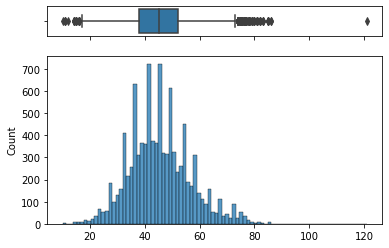

In [47]:
#Number of bits set per molecule
import seaborn as sns

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_box)
sns.histplot(Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [48]:
Morganfingerprint_table.iloc[:, :-1].sum().sort_values(ascending=False)

Mfp1380    9800
Mfp1873    9609
Mfp1750    8995
Mfp807     7485
Mfp1057    7301
           ... 
Mfp822        8
Mfp498        7
Mfp1890       6
Mfp830        6
Mfp337        5
Length: 2048, dtype: int64

In [49]:
bits = bits= list(range(0, 2048, 1))
bits[-1]

2047

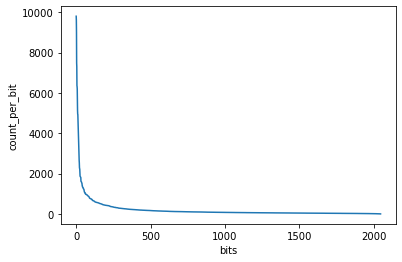

In [50]:
#Number of times each individual bit is set
#Number of bits set per molecule
import seaborn as sns

count_per_bit = Morganfingerprint_table.iloc[:, :-1].sum().sort_values(ascending=False).values
bits = bits= list(range(0, 2048, 1))

#create dataframe using two list days and temperature
bit_counts_df = pd.DataFrame({"count_per_bit":count_per_bit, "bits":bits})
 
# Draw line plot
sns.lineplot(y = "count_per_bit", x = "bits", data=bit_counts_df,)
plt.show() # to show graph



In [51]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

In [52]:
selected_Features = fs_variance(Morganfingerprint_table.iloc[:,:-1], threshold=0.05)

In [53]:
len(selected_Features)

157

In [1]:
2048-157

1891

In [54]:
new_Morganfingerprint_table= Morganfingerprint_table[selected_Features]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


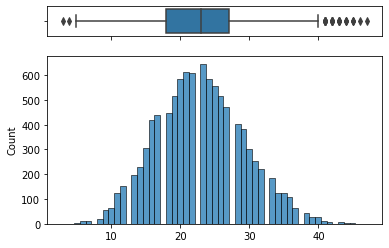

In [55]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(new_Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_box)
sns.histplot(new_Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

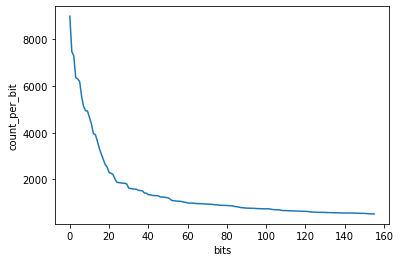

In [56]:
count_per_bit = new_Morganfingerprint_table.iloc[:, :-1].sum().sort_values(ascending=False).values
bits = bits= list(range(0, len(count_per_bit), 1))

#create dataframe using two list days and temperature
bit_counts_df = pd.DataFrame({"count_per_bit":count_per_bit, "bits":bits})
 
# Draw line plot
sns.lineplot(y = "count_per_bit", x = "bits", data=bit_counts_df,)
plt.show() # to show graph



In [57]:
new_Morganfingerprint_table["InChICode_standardised"]= Morganfingerprint_table["InChICode_standardised"]
new_Morganfingerprint_table

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Mfp1,Mfp2,Mfp14,Mfp18,Mfp45,Mfp80,Mfp94,Mfp114,Mfp116,Mfp145,...,Mfp1920,Mfp1928,Mfp1956,Mfp1959,Mfp1963,Mfp1970,Mfp1991,Mfp2004,Mfp2009,InChICode_standardised
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C14H13N5O5S2/c1-2-5-3-25-12-8(11(21)1...
1,1,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C22H21NO2S/c23-20(21(24)25)16-26-22(1...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C15H8O7/c16-6-3-8-12(10(18)4-6)14(20)...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C8H10O4/c1-5(2)8(10)6(11-3)4-7(9)12-8...
4,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C14H14O4S2/c15-5-7-19-13-11(17)9-3-1-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,InChI=1S/C11H8O3/c1-7(12)9-6-8-4-2-3-5-10(8)14...
9872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C15H18N2/c1-2-7-14-12(5-1)13-6-3-4-11...
9873,1,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C33H44N4O4/c1-22-18-37(23(2)20-38)32(...
9874,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C18H16NO/c1-14-11-12-19(17-10-6-5-9-1...


In [58]:
new_Morganfingerprint_table.to_csv("Mfp_filtered_9876.csv", index=False)